In [1]:
cd '/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix/'

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torchvision.models as models
import torchvision

import torch
from PIL import Image
import torchvision.transforms as transforms

import matplotlib.pyplot as plt 
import ipdb
from matplotlib.pyplot import figure

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import ipdb
import copy
from tqdm import trange
from PIL import Image
import PIL
import numpy as np
import torchvision

_device = torch.device('cuda:0')

In [4]:
torch.cuda.empty_cache()


In [6]:
torch.cuda.memory_reserved()

0

In [4]:
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [ ]:
model = models.resnext50_32x4d(pretrained=True)
model.to(_device)
print('loaded')

In [6]:
data_path = '/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix/notebook/images/'
image_1 = Image.open(data_path+'Bernese_mountain_dog_239.JPEG')
image_2 = Image.open(data_path+'Persian_cat_283.JPEG')
image_3 = Image.open(data_path+'Shetland_sheepdog_230.JPEG')
image_4 = Image.open(data_path+'tabby_cat_3_281.png')
image_5 = Image.open(data_path+'African_hunting_dog_275.JPEG')
image_6 = Image.open(data_path+'French_bulldog_245.JPEG')
target_1 = torch.tensor([239],device=_device)
target_2 = torch.tensor([283],device=_device)
target_3 = torch.tensor([230],device=_device)
target_4 = torch.tensor([281],device=_device)
target_5 = torch.tensor([275],device=_device)
target_6 = torch.tensor([245],device=_device)

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize([200,200])
])

img_1 = (transform(image_1)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
img_2 = (transform(image_2)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
img_3 = (transform(image_3)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
img_4 = (transform(image_4)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
img_5 = (transform(image_5)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
img_6 = (transform(image_6)[:3,:,:].float()/255.).unsqueeze(0).to(_device)

blurr = torchvision.transforms.GaussianBlur(21, sigma=(13, 13))

x = torch.cat([img_1,img_2,img_3,img_4,img_5,img_6]).repeat(18,1,1,1)
y = torch.cat([target_1,target_2,target_3,target_4,target_5,target_6]).repeat(18)

In [7]:
y.shape

torch.Size([108])

In [8]:
model.eval()

delta = torch.zeros_like(x, requires_grad = True,device=_device)
yp = model(x+delta)
loss = torch.nn.CrossEntropyLoss()(yp, y)
loss.backward()

grad = blurr(delta.grad.detach().abs().mean(dim=1,keepdim=True))

# delta = torch.zeros_like(img_2, requires_grad = True,device=_device)
# yp = model(img_2+delta)
# loss = torch.nn.CrossEntropyLoss()(yp, target_2)
# loss.backward()

# grad_2 = blurr(delta.grad.detach().abs().mean(dim=1)).squeeze()

In [12]:
grad.requires_grad

False

In [9]:
x_1 = x[:3,:,:,:]
x_2 = x[3:,:,:,:]
grad_1 = grad[:3,:,:]
grad_2 = grad[3:,:,:]

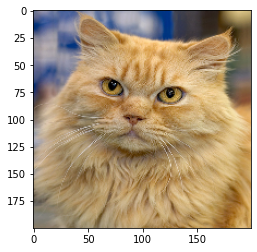

In [10]:
plt.imshow(x_1[1].squeeze().permute(1, 2, 0).cpu().numpy())

In [28]:
max_criteria = torch.zeros([x_1.shape[0]]).cuda()
best_position = torch.zeros([x_1.shape[0],2]).cuda()
mixed_imgs = torch.zeros_like(x_1).cuda()
mixed_lam = torch.zeros([x_1.shape[0]]).cuda()

normalized_grad_1 = grad_1/grad_1.amax(dim=[1,2],keepdim=True)
padded_grad_1 = torch.nn.functional.pad(grad_1, [200,200,200,200], mode='constant', value=0.0)
padded_normalized_grad_1 = torch.nn.functional.pad(normalized_grad_1, [200,200,200,200], mode='constant', value=0.0)
padded_x_1 = torch.nn.functional.pad(x_1, [200,200,200,200], mode='constant', value=0.0)


# saliency_sum = []
for i in range(0, 400, 10):
    for j in range(0, 400, 10):
        normalized_grad_2 = grad_2/grad_2.amax(dim=[1,2],keepdim=True)
        padded_grad_2 = torch.nn.functional.pad(grad_2, [200-j,200+j,0+i,400-i], mode='constant', value=0.0)
        padded_normalized_grad_2 = torch.nn.functional.pad(normalized_grad_2, [200-j,200+j,0+i,400-i], mode='constant', value=0.0)
        padded_x_2 = torch.nn.functional.pad(x_2, [200-j,200+j,0+i,400-i], mode='constant', value=0.0)
        
#         M = blurr((padded_normalized_grad_1 / (padded_normalized_grad_1+padded_normalized_grad_2+1e-6)).unsqueeze(0)).squeeze()
        M = padded_normalized_grad_1 / (padded_normalized_grad_1+padded_normalized_grad_2+1e-6)
        lambbda = M[:,200:400,200:400].mean(dim=[1,2])
#         ipdb.set_trace()
        
        M_adjusted = M.unsqueeze(1).repeat(1,3,1,1)
        
#         mixed_img = (padded_img_1 * M_dim_adjusted)[:,:,200:400,200:400] + (padded_img_2 * (1-M_dim_adjusted))[:,:,200:400,200:400]
#         mixed_saliency = (padded_grad_1 * M)[200:400,200:400] + (padded_grad_2 * (1-M))[200:400,200:400]
        mixed_saliency = (padded_normalized_grad_1 * M)[:,200:400,200:400] + (padded_normalized_grad_2 * (1-M))[:,200:400,200:400]
        
        criteria = mixed_saliency.sum(dim=[1,2])
        update_needed = ((criteria - max_criteria)>0)
        if update_needed.sum() >0:
            mixed_imgs[update_needed,:,:,:] = (padded_x_1 * M_adjusted)[update_needed,:,200:400,200:400] + (padded_x_2 * (1-M_adjusted))[update_needed,:,200:400,200:400]
            mixed_lam[update_needed] = lambbda[update_needed]
            position = torch.tensor([i,j],dtype=torch.float32,device=_device)
            best_position[update_needed,:] = position
            max_criteria[update_needed] = criteria[update_needed]

In [9]:
from utils_mixup import gradmix_v2

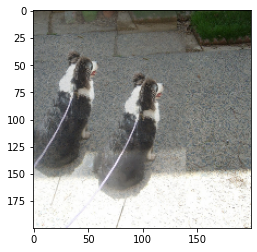

In [20]:
mixed_x, mixed_y, mixed_lam = gradmix_v2(x,y,grad,20)
plt.imshow(mixed_x[2].squeeze().permute(1, 2, 0).cpu().numpy())

In [16]:
mixed_y.shape

AttributeError: 'list' object has no attribute 'shape'

In [29]:
best_position

tensor([[300.,  70.],
        [280.,  90.]], device='cuda:0')

In [19]:
mixed_lam

tensor([0.7986, 0.8286], device='cuda:0')

In [26]:
padded_x_1.shape

torch.Size([2, 3, 600, 600])

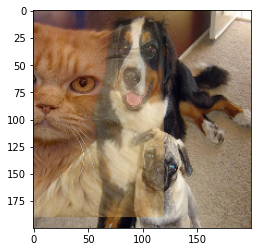

In [22]:
plt.imshow(mixed_x[0].squeeze().permute(1, 2, 0).cpu().numpy())

Text(0.5, 1.0, 'mixed images with our method')

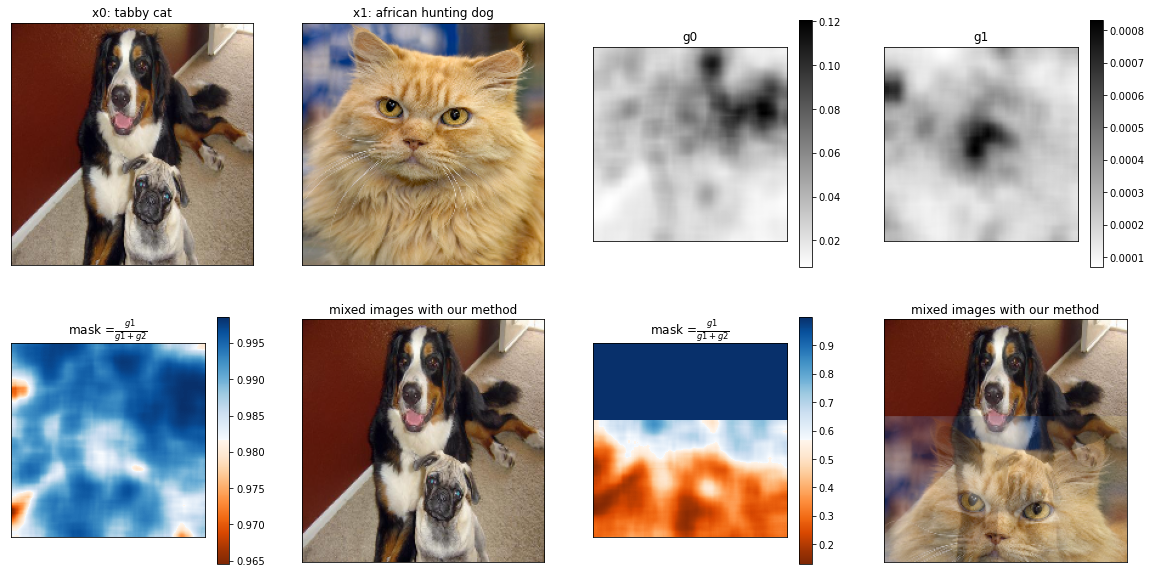

In [198]:
fix, axs = plt.subplots(ncols=4, nrows=2, squeeze=True, figsize=(20,10))

# for i,ax in enumerate(axs.flat):
im = axs.flat[0].imshow(img_1.squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[0].set_title('x0: tabby cat')
im = axs.flat[1].imshow(img_2.squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[1].set_title('x1: african hunting dog')

im = axs.flat[2].imshow(grad_1.t().permute(1,0).cpu().numpy(), cmap = 'binary')
axs.flat[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[2])
axs.flat[2].set_title('g0')

im = axs.flat[3].imshow(grad_2.t().permute(1,0).cpu().numpy(), cmap = 'binary')
axs.flat[3].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[3])
axs.flat[3].set_title('g1')

saliency_M = grad_1.t().permute(1,0).cpu().numpy()/(grad_2.t().permute(1,0).cpu().numpy()+grad_1.t().permute(1,0).cpu().numpy()+1e-6)
im = axs.flat[4].imshow(saliency_M, cmap = newcmp)
axs.flat[4].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[4])
axs.flat[4].set_title(r'mask =$\frac{g1}{g1+g2}$')

mixed_x = (torch.tensor(saliency_M).cuda().unsqueeze(2) * img_1.squeeze().permute(1,2,0)) + (torch.tensor(1-saliency_M).cuda().unsqueeze(2) * img_2.squeeze().permute(1,2,0))
im = axs.flat[5].imshow(mixed_x.cpu().numpy())
axs.flat[5].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[5].set_title('mixed images with our method')

# saliency_M = grad_1.t().permute(1,0).cpu().numpy()/(grad_2.t().permute(1,0).cpu().numpy()+grad_1.t().permute(1,0).cpu().numpy()+1e-6)
im = axs.flat[6].imshow(final_M, cmap = newcmp)
axs.flat[6].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[6])
axs.flat[6].set_title(r'mask =$\frac{g1}{g1+g2}$')

im = axs.flat[7].imshow(final_img.squeeze().permute(1,2,0).cpu().numpy())
axs.flat[7].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[7].set_title('mixed images with our method')

# # plt.show()

In [ ]:
fix, axs = plt.subplots(ncols=3, nrows=1, squeeze=True, figsize=(16,4))

# saliency_dog_padded = m(saliency_dog)[224:,224:]
# img_dog_padded = m(x_dog)[:,:,224:,224:]

# saliency_dog_padded = m(saliency_dog)[224:,112:112+225]
# img_dog_padded = m(x_dog)[:,:,224:,112:112+225]

# saliency_dog_padded = m(saliency_dog)[224:,0:225]
# img_dog_padded = m(x_dog)[:,:,224:,0:225]

# saliency_dog_padded = m(saliency_dog)[112:112+225,224:224+225]
# img_dog_padded = m(x_dog)[:,:,112:112+225,224:224+225]

# saliency_dog_padded = m(saliency_dog)[112:112+225,112:112+225]
# img_dog_padded = m(x_dog)[:,:,112:112+225,112:112+225]

# saliency_dog_padded = m(saliency_dog)[112:112+225,0:225]
# img_dog_padded = m(x_dog)[:,:,112:112+225,0:225]

# saliency_dog_padded = m(saliency_dog)[0:225,224:224+225]
# img_dog_padded = m(x_dog)[:,:,0:225,224:224+225]

# saliency_dog_padded = m(saliency_dog)[0:225,112:112+225]
# img_dog_padded = m(x_dog)[:,:,0:225,112:112+225]

saliency_dog_padded = m(saliency_dog)[0:225,0:225]
img_dog_padded = m(x_dog)[:,:,0:225,0:225]



saliency_M = saliency_dog_padded.t().permute(1,0).cpu().numpy()/(saliency_dog_padded.t().permute(1,0).cpu().numpy()+saliency_cat.t().permute(1,0).cpu().numpy()+1e-6)

im = axs.flat[0].imshow(saliency_dog_padded.t().permute(1,0).cpu().numpy(), cmap = 'binary')
axs.flat[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[0])

im = axs.flat[1].imshow(saliency_M, cmap = newcmp)
axs.flat[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[1])

mixed_x = (torch.tensor(saliency_M).cuda().unsqueeze(2) * img_dog_padded.squeeze().permute(1,2,0)) + (torch.tensor(1-saliency_M).cuda().unsqueeze(2) * x_cat.squeeze().permute(1,2,0))
im = axs.flat[2].imshow(mixed_x.cpu().numpy())
axs.flat[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# axs.flat[2].set_title('mixed images with our method')